In [336]:
    # import the libraies that will be using
import numpy as np
import pandas as pd
import vaex 
import glob

# about how to use vaex and run this jupyter note book
# please install vaex with Anaconda or with regular python intall
# in Anaconda cmd: conda install -c conda-forge vaex
# in regular cmd(python installed): pip install vaex

In [337]:
# open the hdf5 file with vaex, todealing with the large dataset, should convert the csv to hdf5
# caution with Windows operating system, python 3.8 with Windows may cause bugs when dealing with vaex

# After debugging the data, sold_at seems have some relation to expired_at. I don't know why sold_at can't filter out None, it will show error.
# Also, every time I try to catch specific information in the sold_at, such as find which row contains 2019 or 2020, it still shows a lot of None on sold_at column.
# It should output rows that is with stings contains 2019 or 2020 in sold_at but not with None, it seems sold_at column do have some problems.
# I do find when I search sold_at with contains 2019 or 2020, the date such as expired_at, created_at, or updated_on do have some relation to it, even sold_at still shows None.

    # road the hdf5 file
df = vaex.open('listings_hdf5.hdf5')

# to convert csv to hdf5 is to type in cmd with : vaex convert file gaia-dr1.fits gaia-dr1.hdf5



In [338]:
# testing the is_rental correctness
#df['is_rental']
#(df.is_rental.values == 'f').sum() # 3508281
#(df.is_rental.values == 't').sum() # 406839
#(df.is_rental.values != 'f').sum() # 406968
#(df.is_rental.values != 't').sum() # 3508410
df.head(1)

#,address,municipality,province,postal_code,geocoding_type_id,id,mls,price,description,bedrooms,bathrooms,url,search,broker_id,status_id,style_id,created_at,updated_on,the_geom,provider_id,virtual_tour_url,web_bug_url,quad_tree,title,real_estate_board_id,bedrooms_partial,bathrooms_partial,source_id,email,extras,address_components,listing_images_count,parking_spaces,has_garage,has_locker,url_slug,square_footage,kitchen_count,is_rental,expired_at,sold_price,sold_at,thumbnails_count,address_id,address_ids
0,"9099 RIVERSIDE E Unit 704W, WINDSOR, ON, N8S4R1",WINDSOR,ON,N8S4R1,24,3.73021e+06,1600414,129900,'WESTCHESTER AT THE LAKE 7TH FLOOR CONDO WITH 2 ...,1,1,nan,None,144194,2,106,2016-01-19 11:21:23.955684-05,2019-03-30 01:49:12.653968,0101000020E61000001B05D20FB4BB54C06E241AEE6D2B4540,30002,None,nan,0302232120220310302232,None,nan,nan,nan,400787,nan,"'{""lot"": {""irregular_size"": ""800 SQ FT""}, ""type""...","'{""postal"":""N8S4R1"",""street_name"":""Riverside Dri...",20,nan,f,f,9099-riverside-e-unit-704w-windsor-on,None,nan,f,2016-02-13 09:42:33.812-05,nan,None,nan,52907,"{2838,1,2,8307}"


In [339]:
df.describe()

,address,municipality,province,postal_code,geocoding_type_id,id,mls,price,description,bedrooms,...,url_slug,square_footage,kitchen_count,is_rental,expired_at,sold_price,sold_at,thumbnails_count,address_id,address_ids
dtype,str,str,str,str,float64,int64,str,float64,str,float64,...,str,str,float64,str,str,float64,str,float64,float64,str
count,3915249,3914119,3909013,3858369,3505731,3915249,3915249,3913763,3907421,3690058,...,3915249,2578383,2974091,3915120,3587429,691112,613900,1503831,3849194,3858615
NA,0,1130,6236,56880,409518,0,0,1486,7828,225191,...,0,1336866,941158,129,327820,3224137,3301349,2411418,66055,56634
mean,--,--,--,--,22.882743142585667,5336143.436108917,--,581522.0258825024,--,3.0052253921212078,...,--,--,0.9920829591293608,--,--,483661.85834939935,--,21.069484536493796,1206016.7423920436,--
std,--,--,--,--,1.76213,1.1308e+06,--,1.08284e+06,--,1.52657,...,--,--,0.390108,--,--,552604,--,12.3117,795788,--
min,--,--,--,--,1,1,--,0,--,0,...,--,--,0,--,--,0,--,0,9431,--
max,--,--,--,--,27,7294048,--,1e+09,--,1593,...,--,--,11,--,--,4.625e+07,--,100,2.76438e+06,--


In [340]:
    # testing area
#ttt = df[df['sold_price'] > df['price']*3]
#ttt.head(5)

In [341]:
    # analyze and filter out useless information, make it more easy for data analysis and higher correctness.

    # lines that maybe useful
#(df_testna.municipality.isna()).sum()
#(df.municipality.isna()).sum()
#df = df[df['province'].isna() == False]
#df = df[df['province_same'].isna() == False]
#df = df[df['municipality'].isna() == False]
#df = df[df['municipality_same'].isna() == False]
#(df_testna.municipality.isna()).sum()
#(df.municipality.isna()).sum()

    # filter out the null value from several columns
df = df[df['updated_on'].isna() == False]
df = df[df['is_rental'].isna() == False]
    # not using isna() for postal code, because it will cause 2019 data with index error
df = df[df['postal_code'].str.len()>5]
df = df[df['sold_price'].isna() == False]
df = df[df['price'].isna() == False]
    # remove na and also which house type is not house or condo
df = df[df['style_id'].isna() == False]
df = df[df['style_id'] != 24]
df = df[df['style_id'] != 111]

    # filter out the single value of year and month
df['updated_on'].str.replace(' ', '-')
df['time'] = df['updated_on'].str.slice(start=0, stop=7)
df['year'] = df['time'].str.slice(start=0, stop=4)
df = df[df['year'].str.isdigit()]
df = df[df['year'].str.len()==4]
df['month'] = df['time'].str.slice(start=5, stop=7)
    
    # ignore the difference with upper and lower letter and export useful information with regions and postal code
#df['municipality_same'] = df.municipality.str.lower()
df['province_same'] = df.province.str.lower()
df['region_territory'] = df['postal_code'].str.slice(start=0, stop=1)
df['region_territory'] = df['region_territory'].str.upper()
df = df[df['region_territory'].str.isalpha()]
df['region_place'] = df['postal_code'].str.slice(start=0, stop=3)
df['region_place'] = df['region_place'].str.upper()

    # using number of kitchens, parking slots, bedrooms, and bathrooms to find out the size of the house
    # 4 data columns have high data completion
    # the data of square_footage has over 1336866 missing data it may impact the result
    # it is also possible to use square_footage though 
df['home_size'] = df['kitchen_count'] + df['parking_spaces'] + df['bedrooms'] + df['bathrooms']

    # it contains 82% of data with NA value, is a risk to filter it out, need to do it carefully
    # sold_at data do has some problems, most of it only shows None in the column
#df = df[df['sold_at'].isna() == False]

In [342]:
# show whether the deal is in Sep. Use it if only want the Sep. deals.
df['is_sep'] = df['month'] == '09'
df['is_for_sell'] = df['is_rental'] == 'f'

In [343]:
# find the total numbers of each deals that is sold price > list price and list price > sold price
    # earn_passive shows the deal higher than expected, earn_negative shows the deal lower than expected
df['earn'] = df['sold_price'] - df['price']

df['earn_passive'] = df['earn'] > 0
df['earn_negative'] = df['earn'] <= 0

# separate rent and sell only houses, not yet consider the house for both
    
    # this is for house only for sell
    # setting the condition to filter out noise data.
    # need a better improve for this part with a more detailed house price knowledge.
    # Vaex do have the bug when cleaning noise data when using multiple conditions

df_res = df[(df['year'] == '2020')|(df['year'] == '2019')  ]

for_sell = df_res['is_for_sell'] == True
for_rent = df_res['is_for_sell'] == False

df_res = df_res[
    ((df_res['sold_price']<20000000) & (df_res['price']<20000000) & (df_res['sold_price']>40000) & (df_res['sold_price']>40000) & (for_sell)) | 
    ((df_res['sold_price']<40000) & (df_res['price']<40000) & (df_res['sold_price']>100) & (df_res['price']>100) & (for_rent))
]

#df_res = df_res[() & (for_sell)]

#df_res = df_res[(df_res['price']>40000) & (for_sell)]
#df_res = df_res[() & (for_sell)]
    

#df_res = df_res[(df_res['sold_price']<40000) & (for_rent)]
#df_res = df_res[(df_res['sold_price']>100) & (for_rent)]

#df_res = df_res[(df_res['price']<40000) & (for_rent)]
#df_res = df_res[(df_res['price']>100) & (for_rent)]    
    


<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in less


In [344]:
    # columns show which is condo or house
df['condo'] = ((df['style_id'] <= 108) & (df['style_id'] > 104))
df['house'] = ((df['style_id'] > 108) | (df['style_id'] <= 104))
df['home_type'] = df.condo.apply(lambda s: 'condo' if s==True else 'house')


In [345]:
    # filter out useless columns
df_clean = df.drop(['geocoding_type_id','id','mls','url','search','broker_id','the_geom','provider_id','virtual_tour_url'
                   ,'web_bug_url', 'quad_tree', 'title', 'real_estate_board_id', 'bedrooms_partial', 'bathrooms_partial', 'source_id'
                   , 'email', 'listing_images_count'])

In [346]:
#df_clean

In [347]:
#df_clean[(df_clean['house']==False) & (df_clean['condo'] == False)]

In [439]:
# visual the chart plots
import matplotlib.pylab as pltlab
import matplotlib.pyplot as plt
import matplotlib.colors as col
import matplotlib.cm as cm
import scipy.stats as stats


In [440]:
graph_year = '2019'
graph_place = 'L6H'
graph_home = 'condo'
graph_home_type = True
graph_price = 'sold_price'
graph_sellrent = True

In [395]:

# select year
#graph_res = df_clean[df_clean['year']==graph_year]

# select home type
#graph_res = graph_res[graph_res['home_type'] == graph_home]

# price type
#graph_res = graph_res[graph_res[graph_price]]

# select sell or rent
#graph_res = graph_res[graph_res['is_for_sell'] == graph_sellrent]

# select place
#graph_res = graph_res[graph_res['region_place'] == graph_place]

In [396]:
#graph_test1 = graph_res.groupby(['month'], agg={
#                        'mean_price': vaex.agg.mean(graph_price)
#})   #.mean()
#graph_test1 = graph_test1.sort(by = 'month')

In [441]:
# the result of the graph present

# select year
graph_res2 = df_clean[df_clean['year']==graph_year]

# price type
graph_res2 = graph_res2[graph_res2[graph_price]]

# select sell or rent
graph_res2 = graph_res2[graph_res2['is_for_sell'] == graph_sellrent]

# select place
graph_res2 = graph_res2[graph_res2['region_place'] == graph_place]

In [390]:
graph_res2

#,address,municipality,province,postal_code,price,description,bedrooms,bathrooms,status_id,style_id,created_at,updated_on,extras,address_components,parking_spaces,has_garage,has_locker,url_slug,square_footage,kitchen_count,is_rental,expired_at,sold_price,sold_at,thumbnails_count,address_id,address_ids,time,year,month,province_same,region_territory,region_place,home_size,is_sep,is_for_sell,earn,earn_passive,earn_negative,condo,house,home_type
0,"2406 Valley Heights Cres, Oakville, ON, L6H6X2",Oakville,ON,L6H6X2,1298800.0,'Absolutely Spectacular Recently Renovated Execu...,4.0,4.0,3,101,2017-11-10 16:16:29.109184-05,2019-04-02 07:57:57.78036,"'{""lot"": {""unit"": ""feet"", ""depth"": 108.27, ""fron...","'{""postal"":""L6H6X2"",""street"":""2406 Valley Height...",4.0,t,f,2406-valley-heights-cres-oakville-on,None,1.0,f,2018-01-14 00:00:00-05,1275000.0,None,nan,921185.0,"{2829,1,2,7766}",2019-04,2019,04,on,L,L6H,13.0,False,True,-23800.0,False,True,False,True,house
1,"1046 Kent Ave, Oakville, ON, L6H1Z6",Oakville,ON,L6H1Z6,899900.0,'Build Your Dream Home On This Fantastic Buildin...,3.0,2.0,3,101,2017-10-28 14:18:18.294146-04,2019-04-02 06:29:30.706333,"'{""lot"": {""unit"": ""feet"", ""depth"": 187.46, ""fron...","'{""postal"":""L6H1Z6"",""street"":""1046 Kent Ave"",""st...",6.0,f,f,1046-kent-ave-oakville-on,"[1100,1501)",nan,f,2017-10-31 00:00:00-04,890000.0,None,nan,511042.0,"{2829,1,2,7752}",2019-04,2019,04,on,L,L6H,nan,False,True,-9900.0,False,True,False,True,house
2,"338 Riverstone Dr, Oakville, ON, L6H7M3",Oakville,ON,L6H7M3,749000.0,'Beautiful 3-Bdrm End Unit Townhouse On Private ...,3.0,4.0,3,102,2017-10-28 12:21:04.814054-04,2019-04-02 06:29:30.706333,"'{""lot"": {""unit"": ""feet"", ""depth"": 127.99, ""fron...","'{""postal"":""L6H7M3"",""street"":""338 Riverstone Dr""...",3.0,t,f,338-riverstone-dr-oakville-on,"[1500,2001)",2.0,f,2017-11-16 00:00:00-05,738000.0,None,nan,1311431.0,"{2829,1,2,7747}",2019-04,2019,04,on,L,L6H,12.0,False,True,-11000.0,False,True,False,True,house
3,"1131 Riverbank Way, Oakville, ON, L6H6X4",Oakville,ON,L6H6X4,1899000.0,'Beautiful Markay-Built Bungaloft In River Oaks ...,3.0,3.0,3,101,2017-10-31 11:24:58.510131-04,2019-04-02 06:37:52.277174,"'{""lot"": {""unit"": ""feet"", ""depth"": 140.8, ""front...","'{""postal"":""L6H6X4"",""street"":""1131 Riverbank Way...",4.0,t,f,1131-riverbank-way-oakville-on,"[2500,3001)",1.0,f,2017-11-09 00:00:00-05,1860000.0,2017-11-09 00:00:00-05,nan,263402.0,"{2829,1,2,7766}",2019-04,2019,04,on,L,L6H,11.0,False,True,-39000.0,False,True,False,True,house
4,"1217 Eighth Line, Oakville, ON, L6H2H2",Oakville,ON,L6H2H2,599000.0,'Excellent Opportunity In Oakville. Freehold Tow...,3.0,2.0,3,102,2017-10-30 11:22:11.331553-04,2019-04-02 06:37:52.277174,"'{""lot"": {""unit"": ""feet"", ""depth"": 124.15, ""fron...","'{""postal"":""L6H2H2"",""street"":""1217 Eighth Line"",...",3.0,t,f,1217-eighth-line-oakville-on,,1.0,f,2017-11-11 00:00:00-05,594000.0,2017-11-11 00:00:00-05,nan,1311974.0,"{2829,1,2,7746}",2019-04,2019,04,on,L,L6H,9.0,False,True,-5000.0,False,True,False,True,house
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"3,316","1052 Valley Crest Circ, Oakville, ON, L6H6W8",Oakville,ON,L6H6W8,2399000.0,'A Magnificent Backyard For Entertaining! Over 3...,5.0,5.0,3,101,2017-10-27 11:37:54.585804-04,2019-04-02 06:22:40.706888,"'{""lot"": {""unit"": ""feet"", ""depth"": 119.52, ""fron...","'{""postal"":""L6H6W8"",""street"":""1052 Valley Crest ...",9.0,t,f,1052-valley-crest-circ-oakville-on,None,1.0,f,2017-11-23 00:00:00-05,2200000.0,None,nan,1234608.0,"{2829,1,2,7766}",2019-04,2019,04,on,L,L6H,20.0,False,True,-199000.0,False,True,False,True,house
"3,317","#99-1042 Falgarwood Dr, Oakville, ON, L6H2P3",Oakville,ON,L6H2P3,329000.0,'Great Opportunity For First Time Home Buyers Or...,3.0,1.0,3,109,2017-10-27 11:18:53.671437-04,2019-04-02 06:22:40.706888,"'

In [445]:
# input function for condition in selecting values for house price and condo price into two different columns.
# By separating the price, will make the graph easier to reuse and present.
# value nan will be skip when finding the mean value, so it will not impact the final result of the whole mean value.
def fxy(x,y):
    if x == True:
        y = y
    else:
        y = np.nan
    return y

#df['newcolumn'] = df.apply(lambda x: fxy(x['A'], x['B']), axis=1)

graph_res2['house_p'] = graph_res2.apply(fxy, arguments=[graph_res2.house, graph_res2.sold_price])
graph_res2['condo_p'] = graph_res2.apply(fxy, arguments=[graph_res2.condo, graph_res2.sold_price])


In [446]:
# show each month of both mean_price in house and condo
graph_test2 = graph_res2.groupby(['month'], agg={
                        'house_mean_price': vaex.agg.mean('house_p'),
                        'condo_mean_price': vaex.agg.mean('condo_p')
})   #.mean()
graph_test2 = graph_test2.sort(by = 'month')

In [447]:
graph_test2

#,month,house_mean_price,condo_mean_price
0,03,1.02861e+06,428937
1,04,930069,441067
2,05,924844,464773
3,06,936010,471310
4,07,945987,498576
5,08,985250,nan
6,09,947133,511496
7,10,937275,484856
8,11,925055,527671
9,12,966251,465162


Text(0, 0.5, 'mean_price: sold_price')

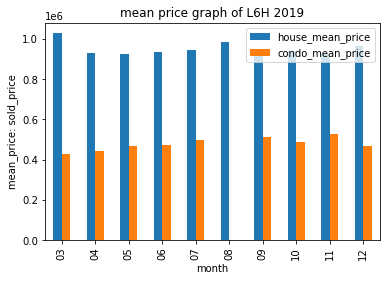

In [451]:
graph_result = graph_test2.to_pandas_df()
graph_result.reset_index().plot(
    x="month", y=["house_mean_price", "condo_mean_price"], kind="bar"
)
plt.title("mean price graph of "+ graph_place + " " + graph_year)
plt.xlabel("month")
plt.ylabel("mean_price: "+ graph_price)

In [435]:
#graph_test3 = graph_res2.groupby(['month','house'], agg={
#                        'mean_price': vaex.agg.mean('sold_price'),
                        
#})   #.mean()
#graph_test3 = graph_test3.sort(by = 'month')

In [356]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [360]:
# df2 = pd.DataFrame(np.random.rand(10, 4), columns=['a', 'b', 'c', 'd'])


#fig, axes = plt.subplots(nrows=2, ncols=2)


#labels = graph_test_res['month']
#house_means = graph_test_res[graph_test_res['house'] == True]
#house_means = house_means['mean_price']
#condo_means = graph_test_res[(graph_test_res['house'] == False) & ]

#condo_means = condo_means['mean_price']

#house_means
#condo_means


        
#df1 = graph_test_res[graph_test_res['house'] ==True]
#df2 = graph_test_res[graph_test_res['house'] ==False]

#df1.plot(ax=axes[0,0], kind='bar')
#df2.plot(ax=axes[0,1], kind='bar')
#df2 = graph_test_res #.DataFrame(graph_test_res.month, columns=['condo', 'house'])
#df2[['condo','house']].plot(kind='bar')
#df2.plot.bar()

#labels
#graph_test_res.plot.bar(x="month", y="mean_price", title="mean price each month in 2019");

In [361]:
#pandas_house_19 = res_house_2019_mean_price.to_pandas_df()
#pandas_house_19.plot.bar(x="month", y="mean_price", title="house mean price each month in 2019");

In [362]:
#pandas_house_20 = res_house_2020_mean_price.to_pandas_df()
#pandas_house_20.plot.bar(x="month", y="mean_price", title="house mean price each month in 2020");

In [363]:
#pandas_condo_20 = res_condo_2020_mean_price.to_pandas_df()
#pandas_condo_20.plot.bar(x="month", y="mean_price", title="condo mean price each month in 2020");

In [364]:
# for the region place data table
sellrent = True
# select sell or rent
df_sell_res = df_clean[grapg_res['is_for_sell'] == graph_sellrent]

In [365]:
    # the result of only grouping month, year, and home_type
df_month = df_sell_res.groupby(['month','year','home_type'],
              agg={'mean_sold': vaex.agg.mean('sold_price'),
                   'mean_price': vaex.agg.mean('price'),
                   'mean_rank': vaex.agg.mean('thumbnails_count'),
                   'mean_size': vaex.agg.mean('home_size'),
                   'min_sold': vaex.agg.min('sold_price'),
                   'min_price': vaex.agg.min('price'),
                   'max_size': vaex.agg.max('home_size'),
                   'popular_area': vaex.agg.count('sold_price'),
                   'sold_above_list_price': vaex.agg.sum('earn_passive'),
                   'sold_below_list_price': vaex.agg.sum('earn_negative')
              }
          )

#pandas_yeah = df_month.to_pandas_df()

<string>:1: RuntimeWarning: invalid value encountered in less_equal


In [366]:
df_month

#,month,year,home_type,mean_sold,mean_price,mean_rank,mean_size,min_sold,min_price,max_size,popular_area,sold_above_list_price,sold_below_list_price
0,06,2019,house,842578.2947263204,850535.0431900792,17.25406852248394,11.605391613046372,12000.0,15000.0,109.0,9354,2377,6977
1,06,2019,condo,567562.7011412268,569802.4015691868,15.836603638958259,5.603542808941375,47500.0,54900.0,268.0,2804,769,2035
2,06,2020,house,917270.5968499511,916557.2265395895,26.62617621899059,10.832890911389205,4300.0,79999.0,62.0,8184,2984,5200
3,06,2020,condo,612440.2578740157,615538.0883014624,22.76827896512936,5.587714116952156,143000.0,149000.0,260.0,1778,478,1300
4,04,2019,house,799564.6873234846,813953.1214543824,nan,11.57012989378951,1.0,2200.0,195.0,115953,23820,92133
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,03,2020,condo,634376.96799117,613442.706401766,16.767328918322296,5.727844782380703,95000.0,101000.0,360.0,2265,1353,912
34,02,2020,house,904681.0096191666,890316.5938816919,17.296706727017323,11.86294911396521,44000.0,44000.0,63.0,6407,3034,3373
35,02,2020,condo,647709.9276948669,634153.8854562738,15.841730038022813,5.570219966159052,30000.0,30000.0,91.0,2104,1122,982
36,11,2019,house,840812.247000993,852377.3908355795,17.318343027379772,11.732238010657193,10000.0,10000.0,87.0,7049,1657,5392


In [367]:
    # the result grouping with place, year, and home type
df_res1 = df_sell_res.groupby(['region_place','year','home_type'],
              agg={'mean_sold': vaex.agg.mean('sold_price'),
                   'mean_price': vaex.agg.mean('price'),
                   'mean_rank': vaex.agg.mean('thumbnails_count'),
                   'mean_size': vaex.agg.mean('home_size'),
                   'min_sold': vaex.agg.min('sold_price'),
                   'min_price': vaex.agg.min('price'),
                   'max_size': vaex.agg.max('home_size'),
                   'popular_area': vaex.agg.count('sold_price'),
                   'sold_above_list_price': vaex.agg.sum('earn_passive'),
                   'sold_below_list_price': vaex.agg.sum('earn_negative')
              }
          )
df_res1
#df_res1.export_csv('res1.csv')

#,region_place,year,home_type,mean_sold,mean_price,mean_rank,mean_size,min_sold,min_price,max_size,popular_area,sold_above_list_price,sold_below_list_price
0,M1E,2019,house,673325.5950617284,669742.975308642,16.035971223021583,10.070175438596491,105000.0,100000.0,23.0,1215,395,820
1,M1E,2019,condo,354280.3027522936,356767.3944954128,16.16949152542373,6.65748031496063,57100.0,42500.0,197.0,327,91,236
2,M1E,2020,house,509168.67139959434,502065.90263691684,21.37102473498233,8.5439672801636,105000.0,105000.0,24.0,493,157,336
3,M1E,2020,condo,239205.3908045977,242364.05747126436,18.98,5.745664739884393,1150.0,99999.0,10.0,174,30,144
4,M1L,2019,house,767759.4557329463,748274.5210449927,15.704,9.61032028469751,310000.0,329900.0,23.0,689,321,368
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"2,082",E2J,2019,house,159000.0,148000.0,nan,8.0,159000.0,148000.0,8.0,1,1,0
"2,083",L2C,2019,house,719990.0,719990.0,1.0,15.0,719990.0,719990.0,15.0,1,0,1
"2,084",N4Y,2020,house,443000.0,449900.0,9.0,nan,443000.0,449900.0,-inf,1,0,1
"2,085",V9G,2019,house,667000.0,677000.0,19.0,nan,667000.0,677000.0,-inf,1,0,1


In [368]:
    # find the avg of popular deals
    # it means how many houses were sold
mean_pop = df_res1['popular_area'].mean()

df_res1['is_popular'] = df_res1['popular_area'] >= 200
#df_res1

In [369]:
    # find the avg of ranks
    # it means how many avg ranks of the place
total_mean_rank = df_res1['mean_rank'].mean()
#total_mean_rank
df_res1['good_rank'] = df_res1['mean_rank'] >= 18
#df_res1
    # besty ranking
#total_mean_rank = df_res1['mean_rank'].max()

In [370]:
# find specific place of data, please change the 3 character in first_three_postal
first_three_postal = 'L5P'
target_place = df_res1[df_res1['region_place'] == first_three_postal]
target_place

<string>:1: RuntimeWarning: invalid value encountered in greater_equal


#,region_place,year,home_type,mean_sold,mean_price,mean_rank,mean_size,min_sold,min_price,max_size,popular_area,sold_above_list_price,sold_below_list_price,is_popular,good_rank
0,L5P,2019,house,1.6e+06,1.629e+06,nan,11,1.6e+06,1.629e+06,11,1,0,1,False,False
1,L5P,2019,condo,554000,559500,nan,8,554000,559500,8,1,0,1,False,False


In [371]:
    # please change the value you want here
    # changing values here to make further method output different results

# mainly with 2019 and 2020
target_year = '2020'
# house deal avg which is higher than the mean
target_popular = True
# two types: house or condo
target_house_type = 'house'
# do the ranking higher than the mean
is_good_rank = True
# tpye a size for searching
target_size = '6'


In [372]:
# lowest mean sold place
# find cheapest place

# choose a year
lowest_sold_mean = df_res1[(df_res1['year'] == target_year)]
# want popular place or not
lowest_sold_mean = lowest_sold_mean[(lowest_sold_mean['is_popular'] == target_popular)]
# rank good or not
lowest_sold_mean = lowest_sold_mean[(lowest_sold_mean['good_rank'] == is_good_rank)]
# house or condo
lowest_sold_mean = lowest_sold_mean[(lowest_sold_mean['home_type'] == target_house_type)]

# home size
#lowest_sold_mean = lowest_sold_mean[(lowest_sold_mean['mean_size'] >= target_size)]

# find lowest mean place
lowest_sold_mean = lowest_sold_mean[lowest_sold_mean['mean_sold'] == lowest_sold_mean['mean_sold'].min()]

lowest_sold_mean

#,region_place,year,home_type,mean_sold,mean_price,mean_rank,mean_size,min_sold,min_price,max_size,popular_area,sold_above_list_price,sold_below_list_price,is_popular,good_rank
0,L8L,2020,house,429305,419099,20.4348,8.11602,187000,169000,15,230,112,118,True,True


In [373]:
#################################################################################################################



#      no need to check the code below




#################################################################################################################

In [374]:
# place with large size
size_home = df_res1[(df_res1['year'] == target_year)]
lowest_sold_mean = lowest_sold_mean[(lowest_sold_mean['is_popular'] == target_popular)]
lowest_sold_mean = lowest_sold_mean[(lowest_sold_mean['home_type'] == target_house_type)]
lowest_sold_mean = lowest_sold_mean[lowest_sold_mean['mean_sold'] == lowest_sold_mean['mean_sold'].min()]
lowest_sold_mean

#,region_place,year,home_type,mean_sold,mean_price,mean_rank,mean_size,min_sold,min_price,max_size,popular_area,sold_above_list_price,sold_below_list_price,is_popular,good_rank
0,L8L,2020,house,429305,419099,20.4348,8.11602,187000,169000,15,230,112,118,True,True


In [375]:
    # lowest mean sold place 2019
place_lowest_mean_deals_2019 = df_res1[(df_res1['year'] == '2019')]
place_lowest_mean_deals_2019 = place_lowest_mean_deals_2019[place_lowest_mean_deals_2019['mean_sold'] == place_lowest_mean_deals_2019['mean_sold'].min()]
place_lowest_mean_deals_2019

#,region_place,year,home_type,mean_sold,mean_price,mean_rank,mean_size,min_sold,min_price,max_size,popular_area,sold_above_list_price,sold_below_list_price,is_popular,good_rank
0,P0B,2019,condo,47000,47000,nan,nan,47000,47000,-inf,1,0,1,False,False


In [376]:
    # lowest mean sold place 2020
place_lowest_mean_deals_2020 = df_res1[(df_res1['year'] == '2020')]
place_lowest_mean_deals_2020 = place_lowest_mean_deals_2020[place_lowest_mean_deals_2020['mean_sold'] == place_lowest_mean_deals_2020['mean_sold'].min()]
place_lowest_mean_deals_2020

#,region_place,year,home_type,mean_sold,mean_price,mean_rank,mean_size,min_sold,min_price,max_size,popular_area,sold_above_list_price,sold_below_list_price,is_popular,good_rank
0,M3V,2020,condo,1350,1350,nan,5,1350,1350,5,1,0,1,False,False


In [377]:
    # lowest mean sold place 2019 in popular area
pop_place_lowest_mean_deals_2019 = df_res1[(df_res1['year'] == '2019')]
pop_place_lowest_mean_deals_2019 = pop_place_lowest_mean_deals_2019[(pop_place_lowest_mean_deals_2019['is_popular'] == True)]
pop_place_lowest_mean_deals_2019 = pop_place_lowest_mean_deals_2019[pop_place_lowest_mean_deals_2019['mean_sold'] == pop_place_lowest_mean_deals_2019['mean_sold'].min()]
pop_place_lowest_mean_deals_2019

#,region_place,year,home_type,mean_sold,mean_price,mean_rank,mean_size,min_sold,min_price,max_size,popular_area,sold_above_list_price,sold_below_list_price,is_popular,good_rank
0,M3N,2019,condo,201944,208299,11.6308,5.30864,38000,38900,8,202,31,171,True,False


In [378]:
    # lowest mean sold place 2020 in popular area
pop_place_lowest_mean_deals_2020 = df_res1[(df_res1['year'] == '2020')]
pop_place_lowest_mean_deals_2020 = pop_place_lowest_mean_deals_2020[(pop_place_lowest_mean_deals_2020['is_popular'] == True)]
pop_place_lowest_mean_deals_2020 = pop_place_lowest_mean_deals_2020[pop_place_lowest_mean_deals_2020['mean_sold'] == pop_place_lowest_mean_deals_2020['mean_sold'].min()]
pop_place_lowest_mean_deals_2020

#,region_place,year,home_type,mean_sold,mean_price,mean_rank,mean_size,min_sold,min_price,max_size,popular_area,sold_above_list_price,sold_below_list_price,is_popular,good_rank
0,M9R,2020,condo,175249,180082,18.3279,5.23346,43500,79000,8,261,26,235,True,True


In [379]:
    # lowest mean sold house 2019
house_lowest_mean_deals_2019 = df_res1[(df_res1['year'] == '2019')]
house_lowest_mean_deals_2019 = house_lowest_mean_deals_2019[(house_lowest_mean_deals_2019['home_type'] == 'house')]
house_lowest_mean_deals_2019 = house_lowest_mean_deals_2019[house_lowest_mean_deals_2019['mean_sold'] == house_lowest_mean_deals_2019['mean_sold'].min()]
house_lowest_mean_deals_2019

#,region_place,year,home_type,mean_sold,mean_price,mean_rank,mean_size,min_sold,min_price,max_size,popular_area,sold_above_list_price,sold_below_list_price,is_popular,good_rank
0,C0K,2019,house,80000,88000,nan,nan,80000,88000,-inf,1,0,1,False,False


In [380]:
    # lowest mean sold house 2020
house_lowest_mean_deals_2020 = df_res1[(df_res1['year'] == '2020')]
house_lowest_mean_deals_2020 = house_lowest_mean_deals_2020[(house_lowest_mean_deals_2020['home_type'] == 'house')]
house_lowest_mean_deals_2020 = house_lowest_mean_deals_2020[house_lowest_mean_deals_2020['mean_sold'] == house_lowest_mean_deals_2020['mean_sold'].min()]
house_lowest_mean_deals_2020

#,region_place,year,home_type,mean_sold,mean_price,mean_rank,mean_size,min_sold,min_price,max_size,popular_area,sold_above_list_price,sold_below_list_price,is_popular,good_rank
0,P0T,2020,house,53813.5,61500,9.5,nan,14000,18000,-inf,2,0,2,False,False


In [381]:
    # lowest mean sold condo 2019
condo_lowest_mean_deals_2019 = df_res1[(df_res1['year'] == '2019')]
condo_lowest_mean_deals_2019 = condo_lowest_mean_deals_2019[(condo_lowest_mean_deals_2019['home_type'] == 'condo')]
condo_lowest_mean_deals_2019 = condo_lowest_mean_deals_2019[condo_lowest_mean_deals_2019['mean_sold'] == condo_lowest_mean_deals_2019['mean_sold'].min()]
condo_lowest_mean_deals_2019

#,region_place,year,home_type,mean_sold,mean_price,mean_rank,mean_size,min_sold,min_price,max_size,popular_area,sold_above_list_price,sold_below_list_price,is_popular,good_rank
0,P0B,2019,condo,47000,47000,nan,nan,47000,47000,-inf,1,0,1,False,False


In [382]:
    # lowest mean sold condo 2020
condo_lowest_mean_deals_2020 = df_res1[(df_res1['year'] == '2020')]
condo_lowest_mean_deals_2020 = condo_lowest_mean_deals_2020[(condo_lowest_mean_deals_2020['home_type'] == 'condo')]
condo_lowest_mean_deals_2020 = condo_lowest_mean_deals_2020[condo_lowest_mean_deals_2020['mean_sold'] == condo_lowest_mean_deals_2020['mean_sold'].min()]
condo_lowest_mean_deals_2020

#,region_place,year,home_type,mean_sold,mean_price,mean_rank,mean_size,min_sold,min_price,max_size,popular_area,sold_above_list_price,sold_below_list_price,is_popular,good_rank
0,M3V,2020,condo,1350,1350,nan,5,1350,1350,5,1,0,1,False,False


In [383]:
place_best_mean_deals_2019 = df_res1[(df_res1['year'] == '2019')]
place_best_mean_deals_2019 = place_best_deals_2019[place_best_deals_2019['mean_sold'] == place_best_deals_2019['mean_sold'].max()]
place_best_mean_deals_2019

NameError: name 'place_best_deals_2019' is not defined

In [ ]:
place_best_mean_deals_2020 = df_res1[(df_res1['year'] == '2020')]
place_best_mean_deals_2020 = place_best_deals_2020[place_best_deals_2020['mean_sold'] == place_best_deals_2020['mean_sold'].max()]
place_best_mean_deals_2020

In [ ]:
condo_best_deals_2019 = df_res1[(df_res1['year'] == '2019') and (df_res1['mean_sold'].max == True) and  (df_res1['home_type'] == 'condo')]
condo_best_deals_2019

In [ ]:
df_sell_20 = df_sell[df_sell['year'] == '2020']
df_sell_19 = df_sell[df_sell['year'] == '2019']


df_sell_20_sep = df_sell[(df_sell['year'] == '2020') & (df_sell['month'] == '09')]
df_sell_19_sep = df_sell[(df_sell['year'] == '2019') & (df_sell['month'] == '09')]
#df_sell_20 = df_sell[df_sell['updated_on'].str.contains('2020-')]
#df_sell_19 = df_sell[df_sell['updated_on'].str.contains('2019-')]

#df_sell_sep_19 = df_sell[df_sell['year'] == '2019' and df_sell['month'] == '09']
#df_sell_sep_20 = df_sell[df_sell['year'] == '2020' and df_sell['month'] == '09']

#df_testres = df_sell[df_sell['year'].str.len()<4]

In [ ]:
df_sell_19_sep